Importing relevant packages from PyTorch

In [144]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Jan 24 16:02:40 2021

@author: s2110992
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

#mnist_data = datasets.MNIST('data',train=True, download = True, transform = transforms.ToTensor())
#mnist_data = list(mnist_data)[:4096] #data of size powers of 2 works better


Simulating Data

In [222]:
training_data_size = 10000
group_size = training_data_size//2
data_size = 100
data = []
#for i in range(training_data_size):
#    data.append(torch.rand(data_size))
#data_tensor = torch.rand((training_data_size,data_size))
training_set = np.zeros((training_data_size,data_size))
training_set[:group_size,:] = np.random.uniform(size =(group_size,data_size))
training_set[group_size:,:] = np.random.normal(loc = 0.5, size =(group_size,data_size))
#print(training_set[0])
training_set = np.random.permutation(training_set)
#print(training_set[0])
data_tensor = torch.FloatTensor(training_set)
#print(data_tensor[-1])

Training Data and Training Parameters

In [223]:
#Note we can make BATCH_SIZE smaller than training data set then it 
#does iterative gradient steps.
LEARNING_RATE = 1e-3
NUM_ITERS = 1000
BATCH_SIZE = training_data_size

In [224]:
# Creating the architecture of the Neural Network

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder
        self.enc1 = nn.Linear(in_features=data_size, out_features=128)
        self.enc2 = nn.Linear(in_features=128, out_features = 64) 
        self.enc3 = nn.Linear(in_features = 64, out_features = 32) #maybe add 64 -> 32 to increase accuracy
        self.enc4 = nn.Linear(in_features = 32, out_features = 16)
        self.enc5 = nn.Linear(in_features = 16,out_features = 2)
        # decoder 
        self.dec1 = nn.Linear(in_features=2, out_features=16)
        self.dec2 = nn.Linear(in_features=16, out_features=32)#maybe add 64 -> 32 to increase accuracy
        self.dec3 = nn.Linear(in_features=32, out_features=64)
        self.dec4 = nn.Linear(in_features=64, out_features=128)
        self.dec5 = nn.Linear(in_features =128, out_features =data_size)
    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = F.relu(self.enc5(x))
        
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x))
        return x
net = Autoencoder()
print(net)
net(torch.rand(data_size))

Autoencoder(
  (enc1): Linear(in_features=100, out_features=128, bias=True)
  (enc2): Linear(in_features=128, out_features=64, bias=True)
  (enc3): Linear(in_features=64, out_features=32, bias=True)
  (enc4): Linear(in_features=32, out_features=16, bias=True)
  (enc5): Linear(in_features=16, out_features=2, bias=True)
  (dec1): Linear(in_features=2, out_features=16, bias=True)
  (dec2): Linear(in_features=16, out_features=32, bias=True)
  (dec3): Linear(in_features=32, out_features=64, bias=True)
  (dec4): Linear(in_features=64, out_features=128, bias=True)
  (dec5): Linear(in_features=128, out_features=100, bias=True)
)


tensor([0.0000, 0.0930, 0.0000, 0.0000, 0.0000, 0.0404, 0.0617, 0.0058, 0.0000,
        0.0000, 0.0351, 0.0661, 0.0000, 0.0911, 0.0000, 0.0000, 0.0905, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0253, 0.0417, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0055, 0.0029, 0.0000, 0.0000, 0.1607, 0.0051, 0.0000, 0.0768,
        0.0000, 0.1357, 0.0671, 0.0000, 0.0284, 0.0000, 0.0000, 0.0000, 0.0639,
        0.0000, 0.0000, 0.0000, 0.0221, 0.0000, 0.0911, 0.0044, 0.0000, 0.0000,
        0.0474, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0156, 0.0000, 0.0000, 0.0000, 0.0000, 0.0601, 0.1123, 0.0000,
        0.0106, 0.0000, 0.0523, 0.0000, 0.0000, 0.0000, 0.0304, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0168, 0.0751, 0.0635, 0.0000, 0.0196,
        0.0026, 0.0000, 0.0000, 0.0899, 0.0697, 0.0620, 0.0284, 0.0000, 0.0000,
        0.1127], grad_fn=<ReluBackward0>)

In [225]:
#using Mean Square Error as the Loss function.
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [226]:
#Training Step!.
loss_vector = np.zeros(NUM_ITERS)
for epoch in range(NUM_ITERS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i in range(training_data_size):
        # get the inputs
        inputs = data_tensor[i]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        #summing loss to work out current loss.
        running_loss += loss.item()
    loss_vector[epoch] = running_loss
    if (epoch >=10)&(abs(loss_vector[epoch] - loss_vector[epoch - 5])< 0.1)&(abs(loss_vector[epoch] - loss_vector[epoch - 10])<0.1):
        break
    #if epoch%10 ==0:
    print('running loss=',running_loss, 'epoch = ', epoch)
    
print('Finished Training')
low_dim_feat = net.enc5(F.relu(net.enc4(F.relu(net.enc3(F.relu(net.enc2(F.relu(net.enc1(torch.rand(data_size))))))))))
print(low_dim_feat)

running loss= 6326.861489288509 epoch =  0
running loss= 6199.014556750655 epoch =  1
running loss= 6194.966318182647 epoch =  2
running loss= 6193.623000629246 epoch =  3
running loss= 6192.7413754835725 epoch =  4
running loss= 6192.15874312073 epoch =  5
running loss= 6186.252272203565 epoch =  6
running loss= 6167.011599756777 epoch =  7
running loss= 6166.721302293241 epoch =  8
running loss= 6166.440850332379 epoch =  9
running loss= 6166.0899510756135 epoch =  10
running loss= 6165.857026323676 epoch =  11
running loss= 6165.601254820824 epoch =  12
running loss= 6155.932672157884 epoch =  13
running loss= 6139.523905679584 epoch =  14
running loss= 6139.4064672365785 epoch =  15
running loss= 6139.24206224829 epoch =  16
running loss= 6138.935539282858 epoch =  17
running loss= 6114.994682364166 epoch =  18
running loss= 6110.245283253491 epoch =  19
running loss= 6089.898713588715 epoch =  20
running loss= 6089.8321945518255 epoch =  21
running loss= 6089.767433963716 epoch = 

Cluster Feature Plot!

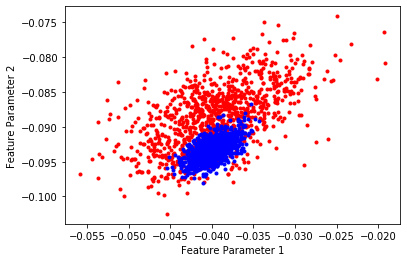

In [233]:
number_of_points = 1000

uniform_points = np.random.uniform(size =(number_of_points,data_size))
uniform_points = torch.FloatTensor(uniform_points)
normal_points = np.random.normal(loc = 0.5,size =(number_of_points,data_size))
normal_points = torch.FloatTensor(normal_points)

normal_feature1 = np.zeros(number_of_points)
normal_feature2 = np.zeros(number_of_points)

uniform_feature1 = np.zeros(number_of_points)
uniform_feature2 = np.zeros(number_of_points)

for i in range(number_of_points):
    uniform_feature = net.enc5(F.relu(net.enc4(F.relu(net.enc3(F.relu(net.enc2(F.relu(net.enc1(uniform_points[i])))))))))
    normal_feature = net.enc5(F.relu(net.enc4(F.relu(net.enc3(F.relu(net.enc2(F.relu(net.enc1(normal_points[i])))))))))
    uniform_feature= uniform_feature.detach().numpy()
    normal_feature = normal_feature.detach().numpy()
    normal_feature1[i] = normal_feature[0]
    normal_feature2[i] = normal_feature[1]
    uniform_feature1[i] = uniform_feature[0]
    uniform_feature2[i] = uniform_feature[1]
    
plt.figure()
plt.xlabel('Feature Parameter 1')
plt.ylabel('Feature Parameter 2')
plt.plot(normal_feature1,normal_feature2,'r.')
plt.plot(uniform_feature1,uniform_feature2,'b.')
plt.show()


Plot Histogram of Latent Parameters for Normal and Uniformly Distributed Points


Plot $L^{2}$ norm between theory and practice (after scale and shifting)

Could implement Variational Autoencoder?

Semi-Supervised -> label normal and uniform distributions (a notion of how ordered a system is)

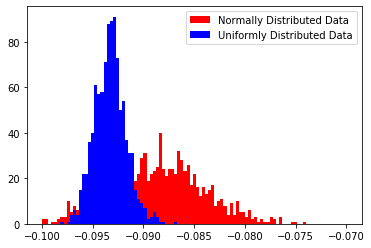

In [236]:
plt.figure()
bins = np.linspace(-0.1, -0.07, 100)
plt.hist(normal_feature2, bins,color = 'red',label = 'Normally Distributed Data')
plt.hist(uniform_feature2, bins,color = 'blue', label = 'Uniformly Distributed Data')
plt.legend(loc='upper right')
plt.show() #make the bar sizes the same!
